# Random Forest Model for Predicting Wildfire Causes
In this notebook, we explore the application of a Random Forest model for predicting and classifying the most probable cause of wildfires based on various characteristics such as location, time, and environmental factors. The dataset used in this analysis is sourced from Kaggle, containing a spatial database of wildfires that occurred in the United States from 1992 to 2015. The goal is to build a supervised machine learning model that accurately classifies the cause of wildfires, which is crucial for understanding and mitigating wildfire risks.

# Abstract

| Original Dataset | SMOTE | Random Under-Sampling (RUS) | KFold Cross Validation |
|-----------------|-----------------|-----------------|-----------------|
 Accuracy : 0.6655 | Accuracy : 0.6434 | Accuracy: 0.4331| Accuracy: 0.6690|




# Imports

In [18]:
# import the cleaned data csv file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold,GridSearchCV 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


# Load Dataset

In [2]:
# read the cleaned data csv file
df = pd.read_csv('cleaned_data.csv')
labels = np.array(df.pop('STAT_CAUSE_DESCR'))

print(labels.shape)
print(df.shape)

# print unique labels
print(np.unique(labels))

# load the encoder
with open('encoders/STAT_CAUSE_DESCR_Encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

# decode the labels
labels = encoder.inverse_transform(labels)
print(np.unique(labels))


(445955,)
(445955, 22)
[ 0  1  2  3  4  5  6  7  8  9 10]
['Arson' 'Campfire' 'Children' 'Debris Burning' 'Equipment Use'
 'Fireworks' 'Lightning' 'Powerline' 'Railroad' 'Smoking' 'Structure']


# Is our Dataset Balanced?

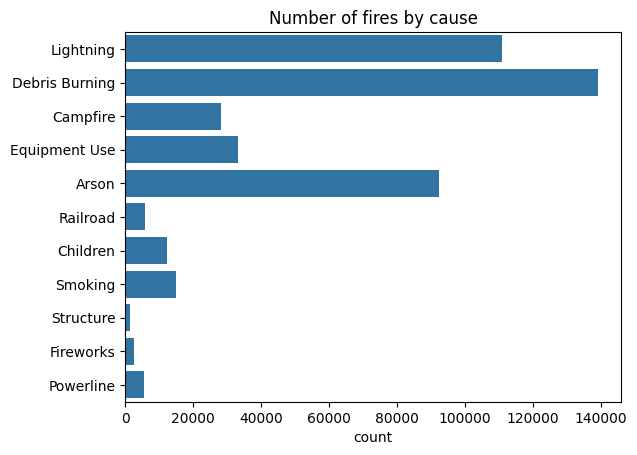

In [3]:
sns.countplot(labels)
plt.title('Number of fires by cause')
plt.show()

# Data Splitting

In [20]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Validation set: {X_val.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Training set: 285411 samples
Validation set: 71353 samples
Test set: 89191 samples


# Hyperparameter Search Using GridSearchCV

##### This hyperparameter search takes many hours to run (5-6 hours), therefore instead of using the `best_model` returned, use the model with the following hyperparameters passed in. The best hyperparameters are `max_depth= None`, `min_samples_leaf=1`, `min_samples_split=2`, `n_estimators=200`,

In [ ]:
# Define hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with training set
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=0)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate best model on the validation set
best_model = grid_search.best_estimator_
val_accuracy = best_model.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Training the Model on the Original Dataset

In [5]:
# train model with random forest
rf_clf = RandomForestClassifier(max_depth= None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6655


#### Check if training set is balanced

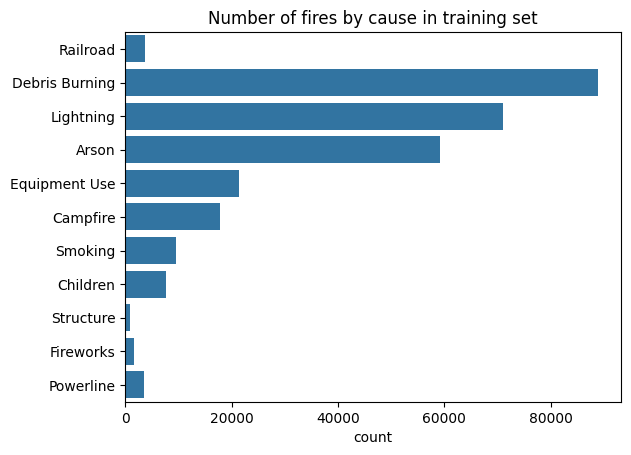

In [7]:
sns.countplot(y_train)
plt.title('Number of fires by cause in training set')
plt.show()

# Using SMOTE to Balance Training Set

Original training data: 285411 samples
SMOTEd training data: 976888 samples


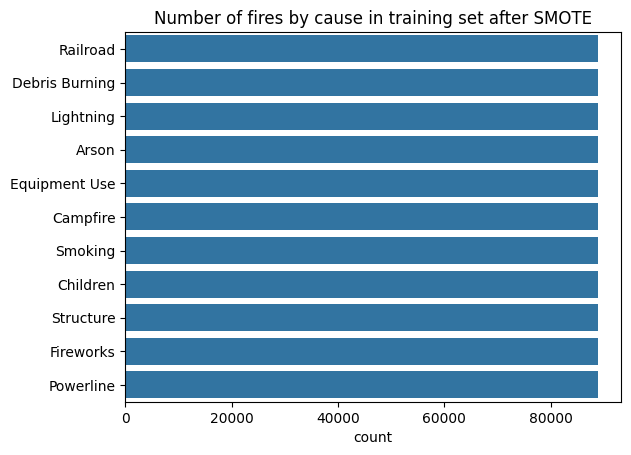

In [8]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print(f'Original training data: {X_train.shape[0]} samples')
print(f'SMOTEd training data: {X_train_smote.shape[0]} samples')

sns.countplot(y_train_smote)
plt.title('Number of fires by cause in training set after SMOTE')
plt.show()

# Using Random Under-Sampling to Balance Training Set

Original training data: 285411 samples
RUSed training data: 9790 samples


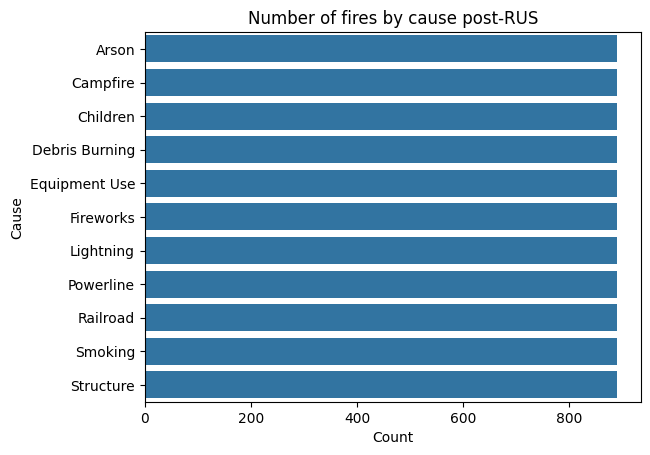

In [21]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print(f'Original training data: {X_train.shape[0]} samples')
print(f'RUSed training data: {X_train_rus.shape[0]} samples')

sns.countplot(y_train_rus)
plt.title('Number of fires by cause post-RUS')
plt.xlabel('Count')
plt.ylabel('Cause')
plt.show()

# Train Using Random Forest Classifier with RUS to Balance Training Set
RUS = Random Under-Sampling

In [22]:
# train model with random forest
rf_clf_rus = RandomForestClassifier(max_depth= None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
rf_clf_rus.fit(X_train_rus, y_train_rus)

# Evaluate the model on the test set
y_pred = rf_clf_rus.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.4331


                precision    recall  f1-score   support

         Arson       0.59      0.39      0.47     18349
      Campfire       0.38      0.55      0.45      5765
      Children       0.09      0.26      0.13      2398
Debris Burning       0.68      0.31      0.42     27826
 Equipment Use       0.31      0.27      0.29      6570
     Fireworks       0.09      0.63      0.16       517
     Lightning       0.89      0.67      0.76     22192
     Powerline       0.09      0.41      0.14      1096
      Railroad       0.10      0.47      0.16      1166
       Smoking       0.16      0.30      0.21      3049
     Structure       0.02      0.58      0.04       263

      accuracy                           0.43     89191
     macro avg       0.31      0.44      0.30     89191
  weighted avg       0.61      0.43      0.49     89191



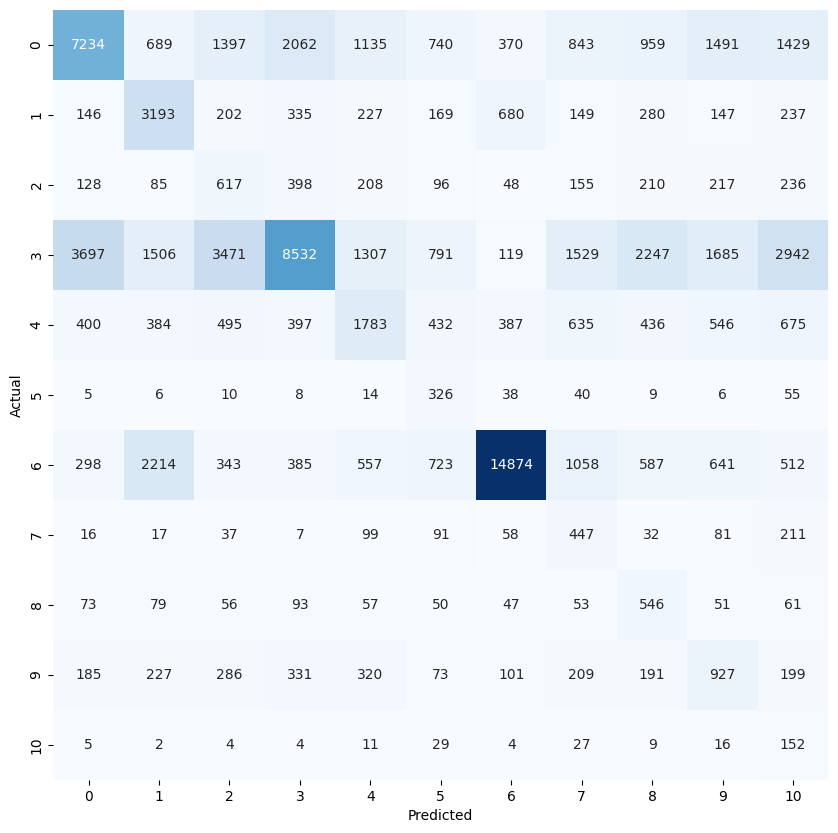

In [23]:
# plot results
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_test, y_pred))

# Train using Random Forest Classifier with SMOTE Training Set

In [7]:
# train model with random forest
rf_clf = RandomForestClassifier(max_depth= None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)
rf_clf.fit(X_train_smote, y_train_smote)

# Evaluate the model on the test set
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6434


                precision    recall  f1-score   support

         Arson       0.63      0.61      0.62     18349
      Campfire       0.55      0.52      0.54      5765
      Children       0.18      0.13      0.15      2398
Debris Burning       0.66      0.71      0.68     27826
 Equipment Use       0.44      0.40      0.42      6570
     Fireworks       0.24      0.36      0.29       517
     Lightning       0.85      0.85      0.85     22192
     Powerline       0.20      0.23      0.21      1096
      Railroad       0.51      0.39      0.44      1166
       Smoking       0.29      0.25      0.27      3049
     Structure       0.05      0.06      0.06       263

      accuracy                           0.64     89191
     macro avg       0.42      0.41      0.41     89191
  weighted avg       0.64      0.64      0.64     89191



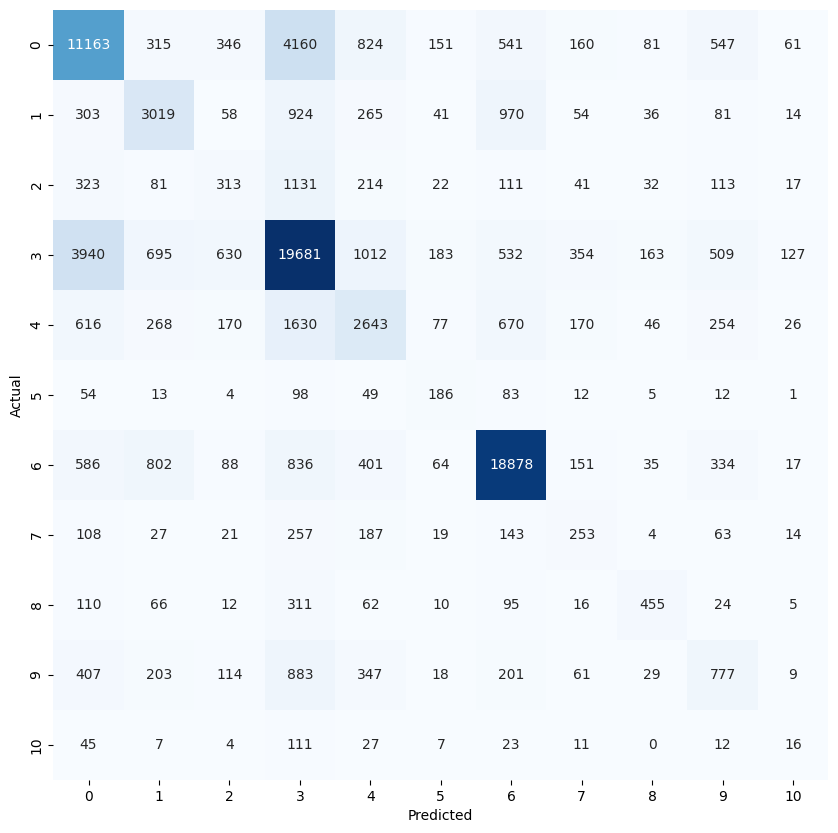

In [8]:
# plot results
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

print(classification_report(y_test, y_pred))

In [9]:
# save the model
with open('models/random_forest_no_kfold.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

# Train using K-fold Cross Validation with Random Forest Classifier

In [9]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []  # To store accuracies for each fold
# best_rf_clf = RandomForestClassifier(**best_params, random_state=42) # Use the best hyperparameters found if grid search was used
best_rf_clf = RandomForestClassifier(max_depth= None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42)

for fold_index, (train_indices, test_indices) in enumerate(skf.split(df, labels), 1):
    print(f"Fold {fold_index}:")
    print("--------")

    X_train_val, X_test = df.iloc[train_indices], df.iloc[test_indices]
    y_train_val, y_test = labels[train_indices], labels[test_indices]

    # Train the model with best hyperparameters on the entire training + validation set
    best_rf_clf.fit(X_train_val, y_train_val)

    # Evaluate model on the test set
    y_pred = best_rf_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    print(f"Accuracy for fold {fold_index}: {accuracy:.4f}\n")

# Calculate average accuracy across all folds
avg_accuracy = np.mean(accuracies)
print(f"Average Accuracy across all folds: {avg_accuracy:.4f}")


Fold 1:
--------
Accuracy for fold 1: 0.6692

Fold 2:
--------
Accuracy for fold 2: 0.6693

Fold 3:
--------
Accuracy for fold 3: 0.6682

Fold 4:
--------
Accuracy for fold 4: 0.6694

Fold 5:
--------
Accuracy for fold 5: 0.6688

Average Accuracy across all folds: 0.6690


# Plot Results

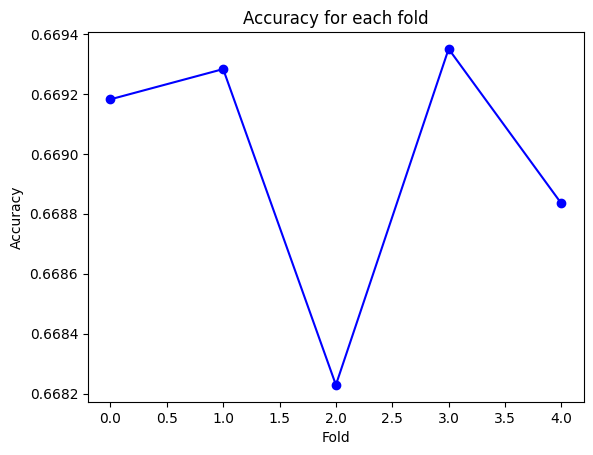

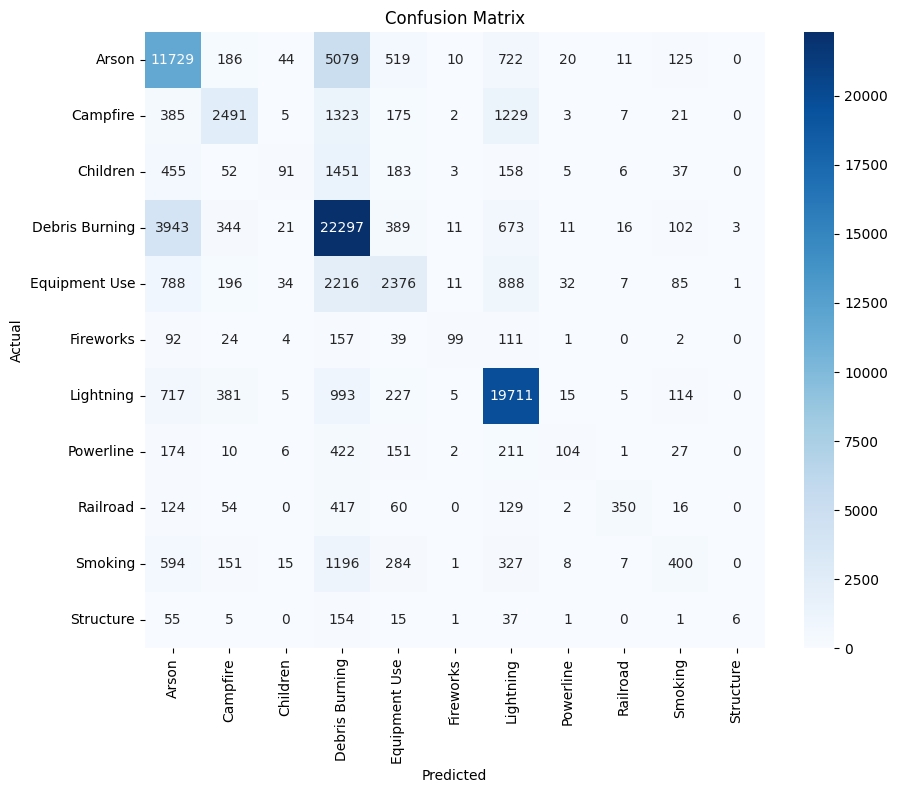

                precision    recall  f1-score   support

         Arson       0.62      0.64      0.63     18445
      Campfire       0.64      0.44      0.52      5641
      Children       0.40      0.04      0.07      2441
Debris Burning       0.62      0.80      0.70     27810
 Equipment Use       0.54      0.36      0.43      6634
     Fireworks       0.68      0.19      0.29       529
     Lightning       0.81      0.89      0.85     22173
     Powerline       0.51      0.09      0.16      1108
      Railroad       0.85      0.30      0.45      1152
       Smoking       0.43      0.13      0.20      2983
     Structure       0.60      0.02      0.04       275

      accuracy                           0.67     89191
     macro avg       0.61      0.35      0.40     89191
  weighted avg       0.65      0.67      0.64     89191



In [10]:
plt.plot(accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy for each fold')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

# Save Model

In [11]:
# save the model
with open('models/RandomForestClassifier.pkl', 'wb') as f:
    pickle.dump(best_rf_clf, f)

# Predicting The Model

In [12]:
with open('models/RandomForestClassifier.pkl', 'rb') as f:
    model = pickle.load(f)

with open('encoders/STAT_CAUSE_DESCR_Encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

In [17]:
# predict
prediction = model.predict(X_test)
# print accuracy
print("Accuracy:", accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))


Accuracy: 0.6688342994248299
                precision    recall  f1-score   support

         Arson       0.62      0.64      0.63     18445
      Campfire       0.64      0.44      0.52      5641
      Children       0.40      0.04      0.07      2441
Debris Burning       0.62      0.80      0.70     27810
 Equipment Use       0.54      0.36      0.43      6634
     Fireworks       0.68      0.19      0.29       529
     Lightning       0.81      0.89      0.85     22173
     Powerline       0.51      0.09      0.16      1108
      Railroad       0.85      0.30      0.45      1152
       Smoking       0.43      0.13      0.20      2983
     Structure       0.60      0.02      0.04       275

      accuracy                           0.67     89191
     macro avg       0.61      0.35      0.40     89191
  weighted avg       0.65      0.67      0.64     89191

